<a href="https://colab.research.google.com/github/ragul1995/TIme_Series/blob/master/09_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.


## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('drive/My Drive/Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Inspect the data (EDA)
Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'> Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. 

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


In [6]:
print(f"Starts from {df.index.min()} ends {df.index.max()}")


Starts from 2016-01-01 00:00:00 ends 2017-05-31 00:00:00


In [7]:
print(f"No of obversations {len(df)}")

No of obversations 517


In [8]:
df.groupby('weekday')['holiday'].mean().round(4)*100

weekday
Friday        9.46
Monday       16.22
Saturday      2.70
Sunday       10.81
Thursday      5.48
Tuesday       2.70
Wednesday     0.00
Name: holiday, dtype: float64

In [9]:
df.groupby('weekday')['total'].sum()

weekday
Friday       10270.0
Monday        6167.0
Saturday     15739.0
Sunday       12263.0
Thursday      6713.0
Tuesday       6381.0
Wednesday     6420.0
Name: total, dtype: float64

## Visualizing data

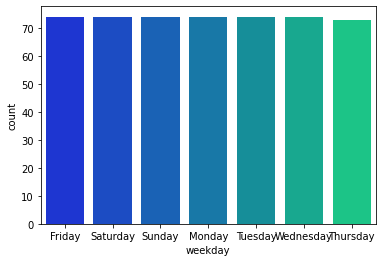

In [10]:
import seaborn as sns

sns.countplot(df['weekday'],palette='winter');

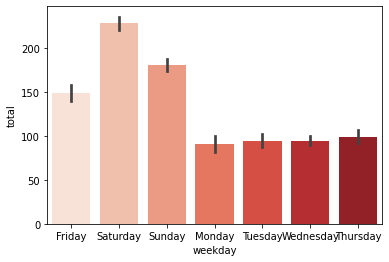

In [11]:
sns.barplot(x=df['weekday'],y=df['total'],palette='Reds');

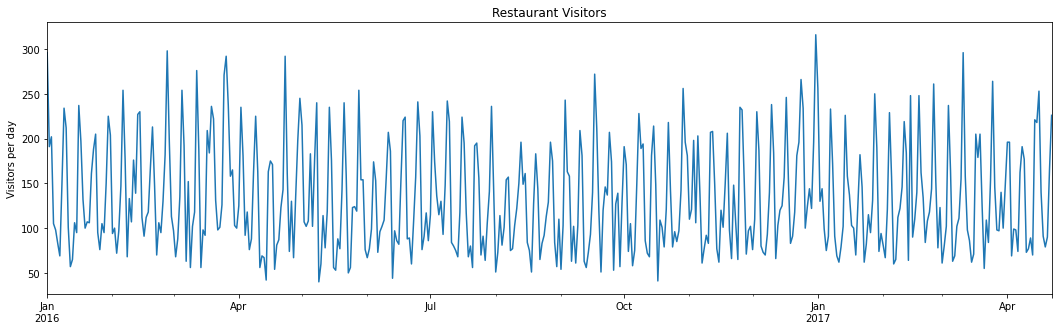

In [12]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(18,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

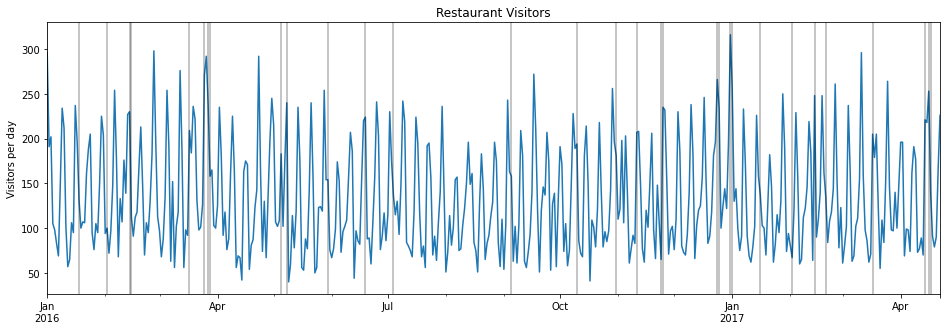

In [13]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### ETS Decomposition

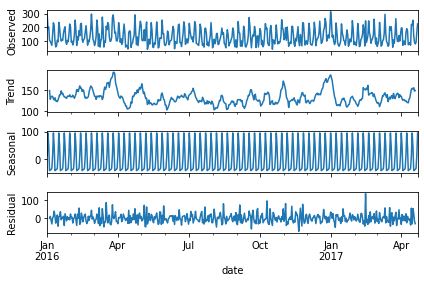

In [14]:
result = seasonal_decompose(df1['total'])
result.plot();

As we can clearly see, there's some seasonality in our dataset. Let's plot only seasonal component for further investigation.

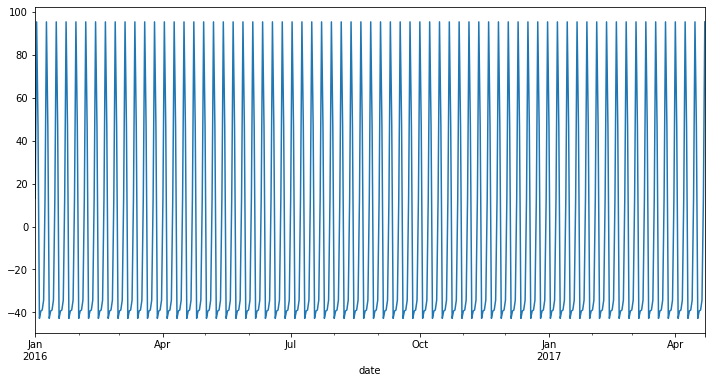

In [61]:
result.seasonal.plot(figsize=(12,6));

In [0]:
# create function to plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,acf
import matplotlib.pyplot as plt

def acf_pacf(ts,alags=40,plags=40):

    '''Takes timeseries and plots ACF and PACF'''
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
    plot_acf(ts,lags=alags, zero=True,ax=ax1)
    plot_pacf(ts,lags=plags, ax=ax2, method = 'ywmle')
    plt.show();

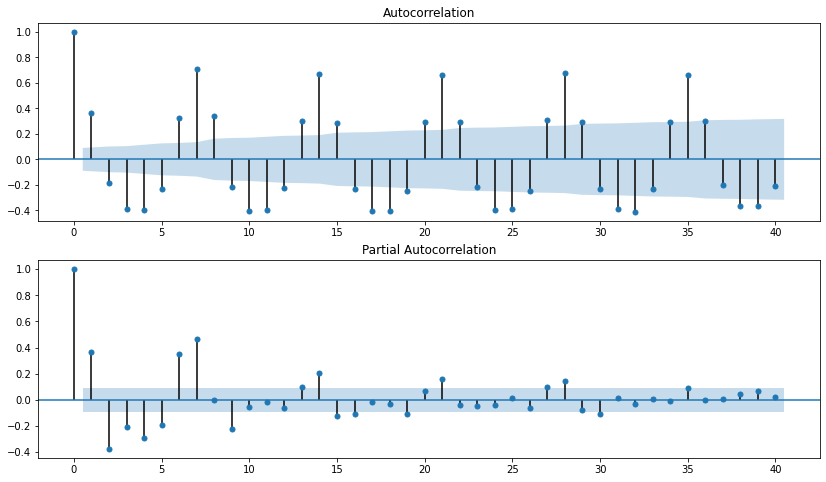

In [16]:
acf_pacf(df1['total'])

## Test for stationarity

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [18]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We can see that our data is stationary, let's further investigate about seasonality before get into model creation.

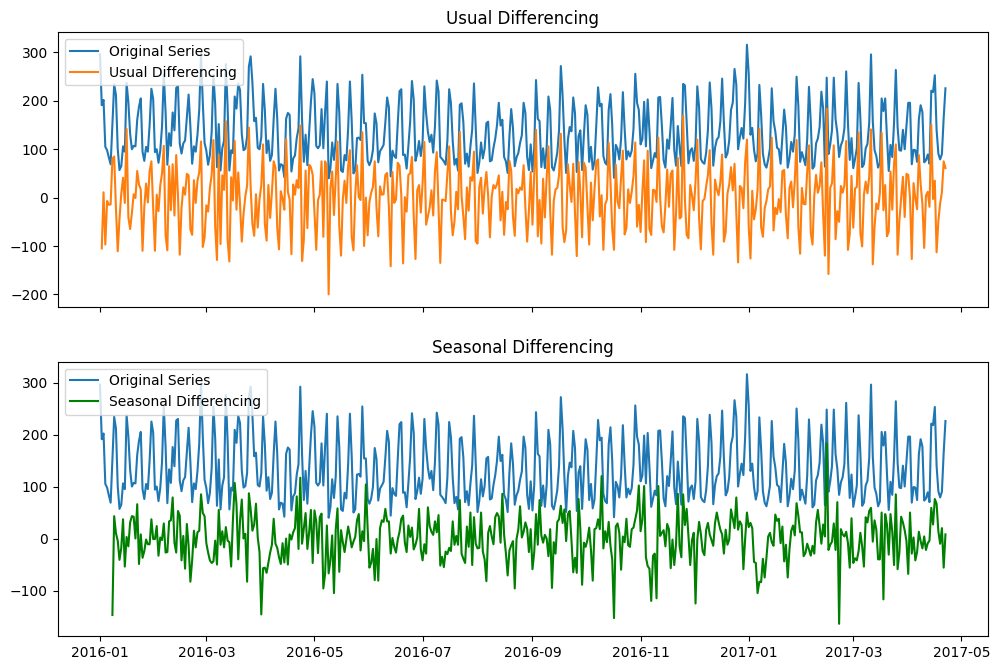

In [56]:
# Usual Differencing

fig, axes = plt.subplots(2, 1, figsize=(12,8), dpi=100, sharex=True)

axes[0].plot(df['total'], label='Original Series')
axes[0].plot(df['total'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Differencing
axes[1].plot(df['total'], label='Original Series')
axes[1].plot(df['total'].diff(7), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10);

### To obtain recommended orders


In [19]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                  478
Model:             SARIMAX(1, 0, 1, 7)   Log Likelihood               -2387.926
Date:                 Sat, 09 May 2020   AIC                           4783.852
Time:                         03:14:45   BIC                           4800.531
Sample:                              0   HQIC                          4790.409
                                 - 478                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.0699      2.102      2.887      0.004       1.949      10.191
ar.S.L7        0.9534      0.016     60.039      0.000       0.922       0.985
ma.S.L7       -0.7315      0.056    -13.101      0.000      -0.841      -0.622
sigma2      1357.6408     88.981     15.258      0.000    1183.242    1532.040
===================================================================================
Ljung-Box (Q):                       73.59   Jarque-Bera (JB):                58.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.73
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (1,0,0) and a seasonal order of (1,0,0,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [20]:
len(df1)

478

In [0]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### SARIMA Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [0]:
def fit_sarimax_model(ts, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
    
    '''Takes a time series and runs a SARIMAX model with parameter order provided. 
    If no parameter provided default is (1,1,1), (0,0,0,12). 
    Has the default option to print model summary and plot diagnostics, which can be turned off'''
  
    # fit model
    model = SARIMAX(ts,
                    order=order,
                    seasonal_order=seasonal_order,
                    trend='ct',
                    enforce_stationarity=True,
                    enforce_invertibility=False)
    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

                                 Statespace Model Results                                
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -2239.885
Date:                           Sat, 09 May 2020   AIC                           4489.770
Time:                                   03:14:46   BIC                           4510.158
Sample:                               01-01-2016   HQIC                          4497.816
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.1864      6.028      5.671      0.000      22.371      46.002
drift         -0.0050      0.013     -0.392

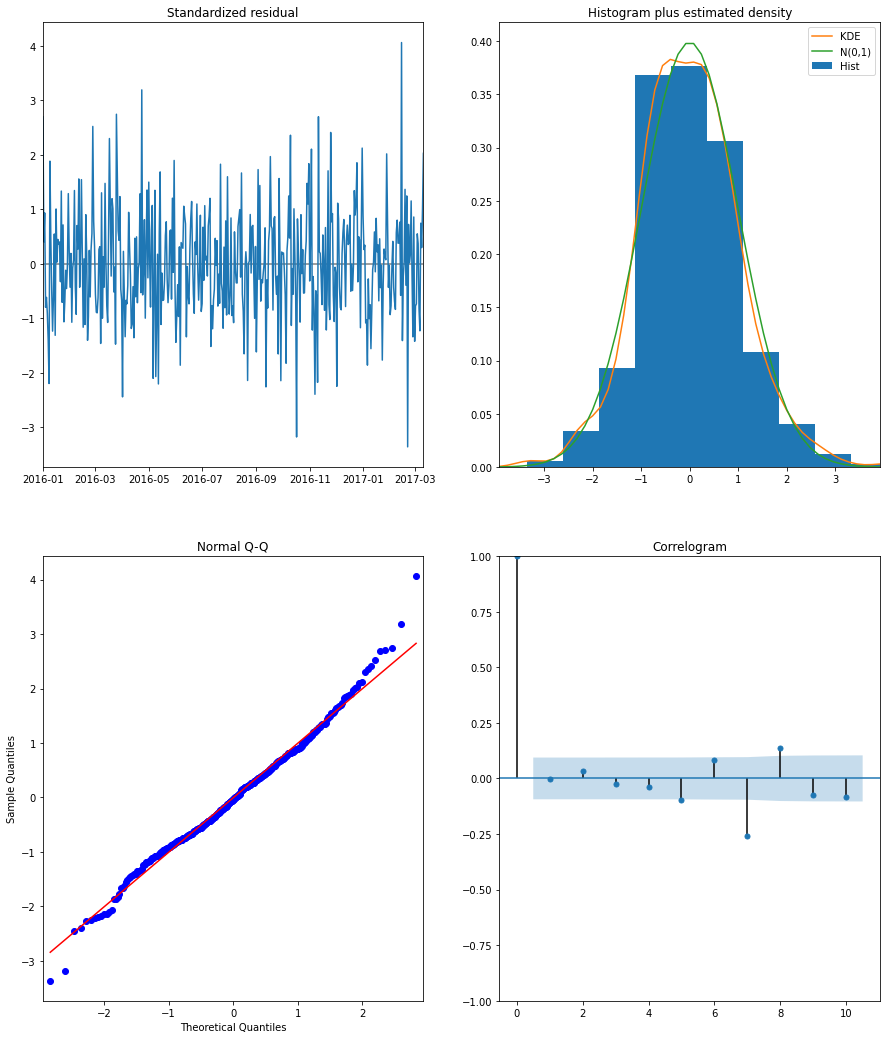

In [23]:
results1 = fit_sarimax_model(train['total'],order=(1,0,0),seasonal_order=(1,0,0,7))

In [0]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions1 = results1.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(1,0,0,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

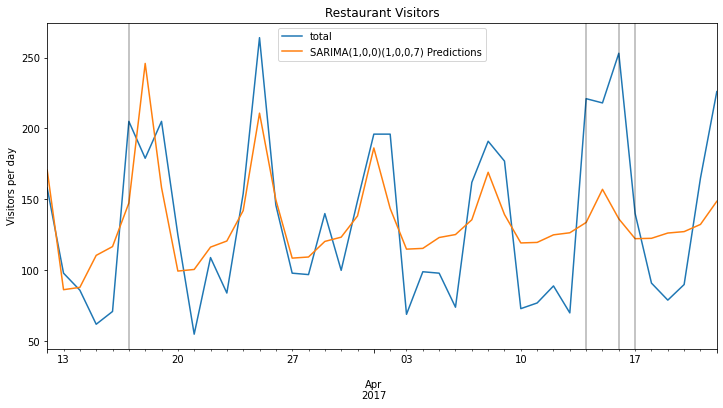

In [27]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions1.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Evaluate the Model

**The commonly used accuracy metrics to judge forecasts are:**

Mean Absolute Percentage Error (MAPE)

Mean Error (ME)

Mean Absolute Error (MAE)

Mean Percentage Error (MPE)

Root Mean Squared Error (RMSE)

Correlation between the Actual and the Forecast (corr)

Min-Max Error (minmax)

In [28]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions1, test['total'])

{'corr': 0.6697033947630479,
 'mae': 36.410435610129106,
 'mape': 0.3143786114945146,
 'me': -0.6081523516435718,
 'minmax': 0.2365696874323726,
 'mpe': 0.12718581265847173,
 'rmse': 43.530174476213986}

In [29]:
from sklearn.metrics import mean_absolute_error,mean_squared_error


mean_squared_error(predictions1,test['total'])**.5

43.530174476213986

In [30]:
#Construct confidence interval
pd.DataFrame(results1.get_forecast(steps=42).summary_frame())


total,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-03-12,170.635710,40.979248,90.317859,250.953560
2017-03-13,86.354782,41.675414,4.672471,168.037093
2017-03-14,87.987508,41.699063,6.258847,169.716169
2017-03-15,110.544890,41.699873,28.814641,192.275139
2017-03-16,116.733751,41.699900,35.003448,198.464054
2017-03-17,147.425362,41.699901,65.695057,229.155667
2017-03-18,245.840489,41.699901,164.110185,327.570794
2017-03-19,158.323864,50.568421,59.211580,257.436148
2017-03-20,99.485715,50.844899,-0.168456,199.139887
2017-03-21,100.619225,50.854346,0.946538,200.291912


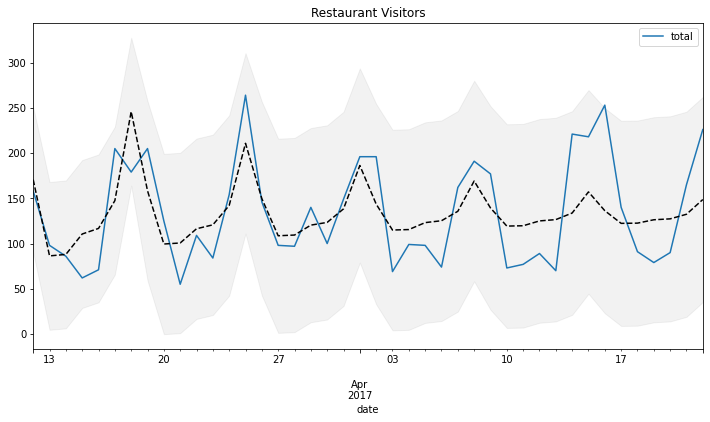

In [31]:
ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)

# Construct the forecasts
fcast = results1.get_forecast(steps=42).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);

## Now add the exog variable (SARIMAX)

In [32]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,0,7),enforce_invertibility=False)
results2 = model.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -2207.493
Date:                           Sat, 09 May 2020   AIC                           4422.986
Time:                                   03:15:52   BIC                           4439.297
Sample:                               01-01-2016   HQIC                          4429.423
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       67.1163      4.134     16.236      0.000      59.014      75.218
ar.L1          0.1970      0.051      3.894      0.000       0.098       0.296
ar.S.L7        0.9503      0.014     68.640      0.000       0.923       0.977
sigma2      1409.0747     89.445     15.754      0.000    1233.766    1584.383
===================================================================================
Ljung-Box (Q):                      119.84   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.00   Prob(JB):                         0.44
Heteroskedasticity (H):               1.03   Skew:                             0.05
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions2 = results2.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,0,7) Predictions')

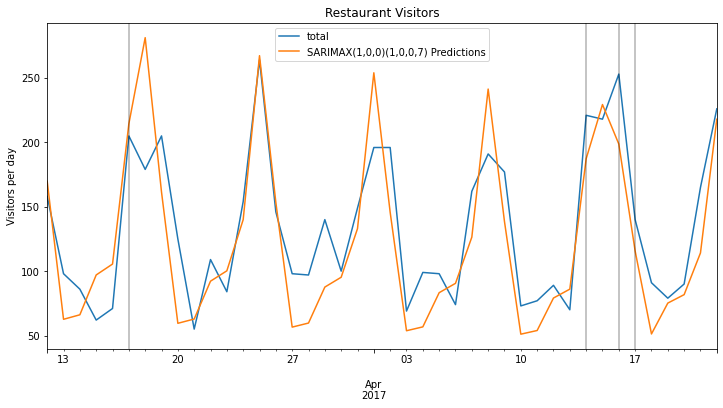

In [35]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions2.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [52]:
pd.DataFrame(results2.get_forecast(steps=42,exog=test[['holiday']]).summary_frame())

total,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-03-12,169.789658,37.537643,96.217229,243.362087
2017-03-13,62.614377,38.259129,-12.372138,137.600892
2017-03-14,66.110034,38.286856,-8.930825,141.150892
2017-03-15,97.034456,38.287932,21.991489,172.077422
2017-03-16,105.501298,38.287973,30.458249,180.544346
2017-03-17,214.412696,38.287975,139.369645,289.455748
2017-03-18,281.281598,38.287975,206.238546,356.324650
2017-03-19,161.346674,52.329920,58.781915,263.911432
2017-03-20,59.500778,52.799663,-43.984661,162.986216
2017-03-21,62.822581,52.817810,-40.698424,166.343586


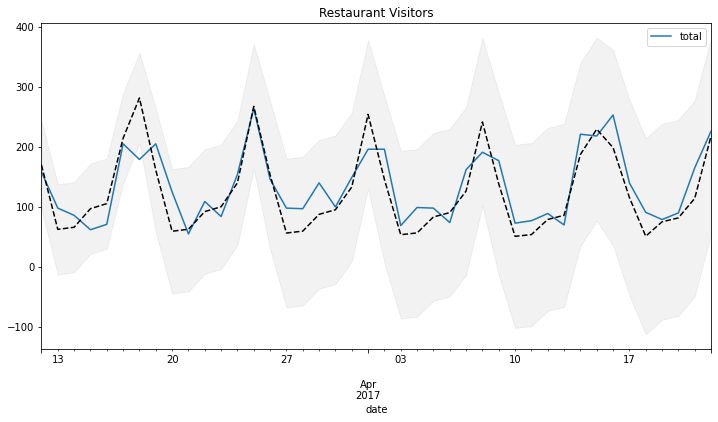

In [50]:
ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)

# Construct the forecasts
fcast = results2.get_forecast(steps=42,exog=test[['holiday']]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);

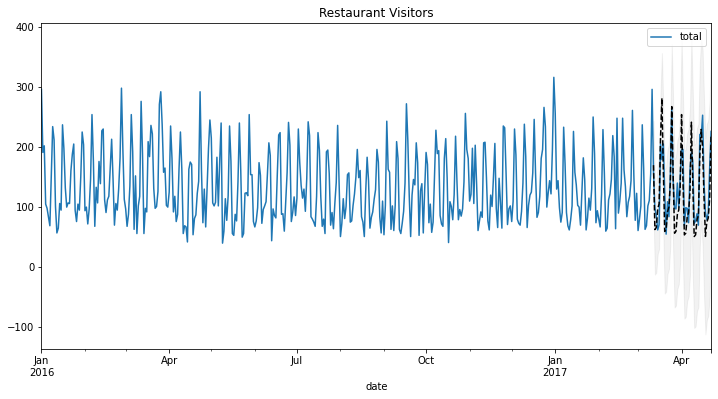

In [51]:
ax = df1['total'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)

# Construct the forecasts
fcast = results2.get_forecast(steps=42,exog=test[['holiday']]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);

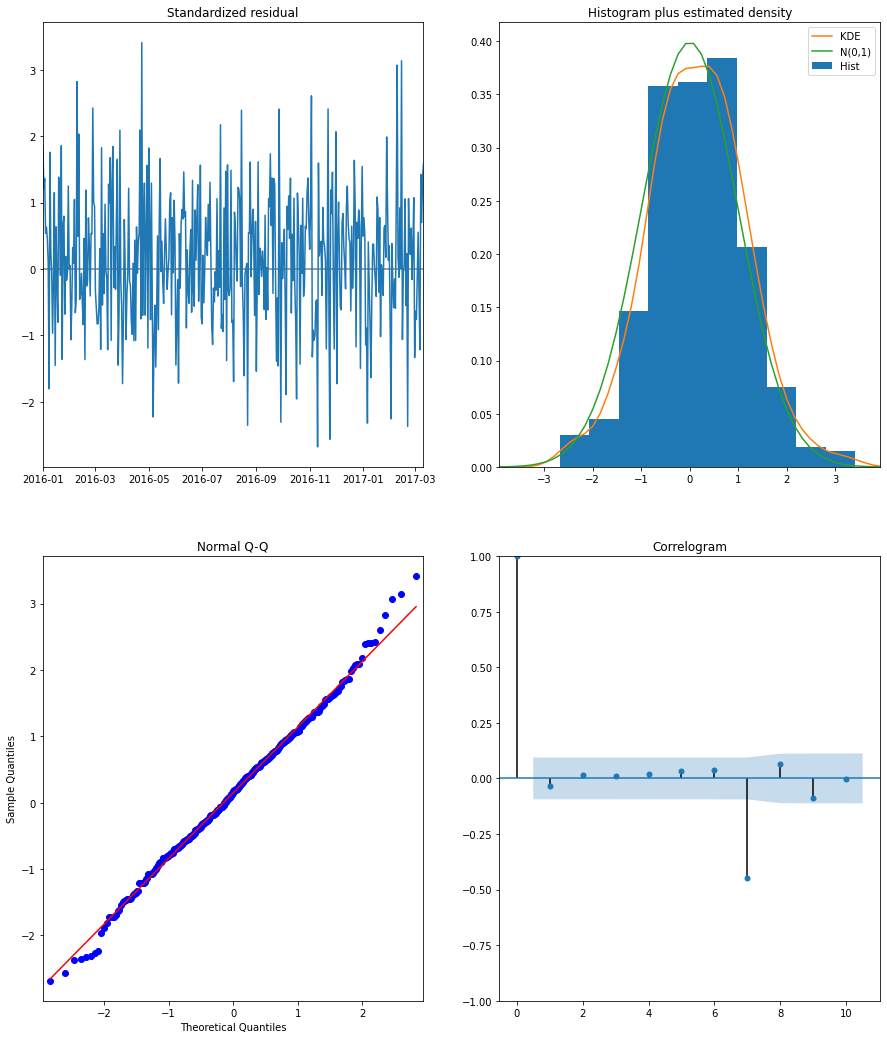

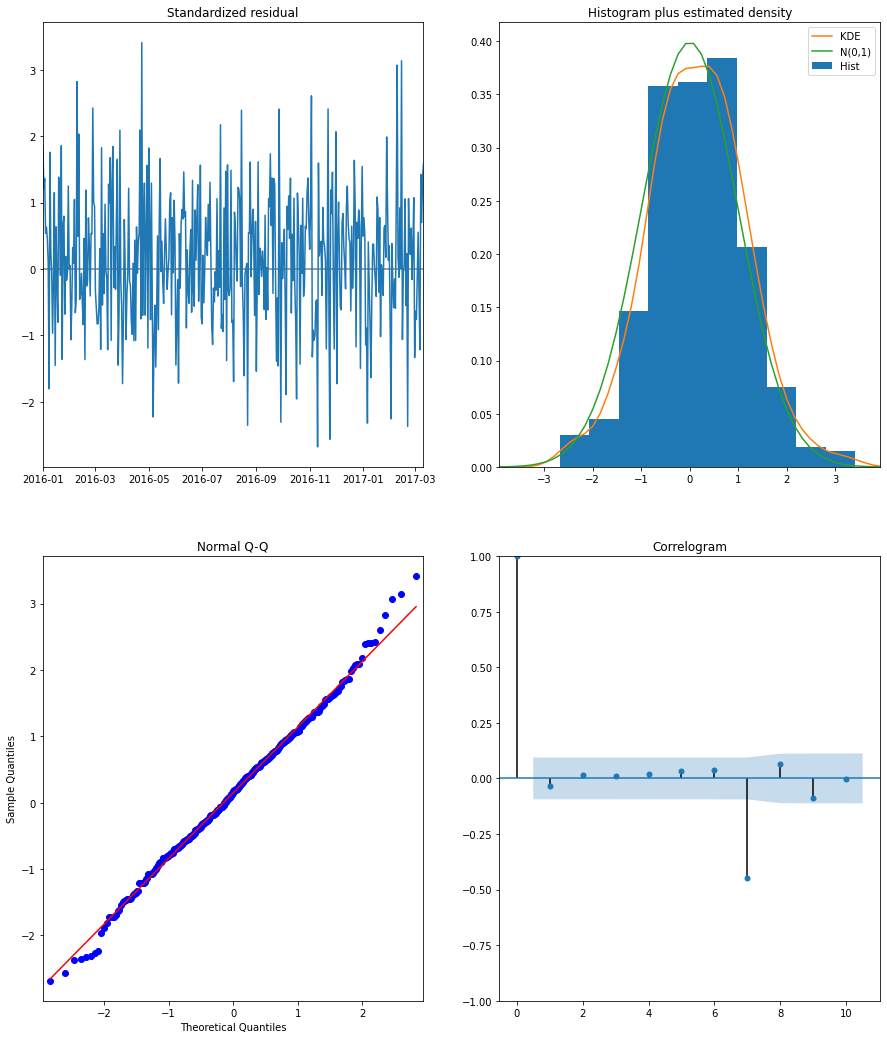

In [44]:
results2.plot_diagnostics(figsize=(15, 18))

So how to interpret the plot diagnostics?

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Righ**t: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [36]:
forecast_accuracy(predictions2,test['total'])

{'corr': 0.8606005192285957,
 'mae': 28.617354230477023,
 'mape': 0.23292196516965818,
 'me': -10.521134753134303,
 'minmax': 0.21296461873320516,
 'mpe': -0.08027700157812762,
 'rmse': 35.23535216027212}

Great! Sarimax with exog variable performed better than sarima model. MAPE decreased almost 8% that means accuracy of model increased from 69 to 77% which is quite great.

In [41]:
#comapring errors

print('SARIMA Model RMSE'  ,{mean_squared_error(predictions1,test['total'])**.5})
print('SARIMAX Model RMSE'  ,{mean_squared_error(predictions2,test['total'])**.5})

SARIMA Model RMSE {43.530174476213986}
SARIMAX Model RMSE {35.23535216027212}


In [42]:
test['total'].describe()

count     42.000000
mean     134.261905
std       58.114714
min       55.000000
25%       86.750000
50%      117.000000
75%      178.500000
max      264.000000
Name: total, dtype: float64

### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [0]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,0,7) Forecast')

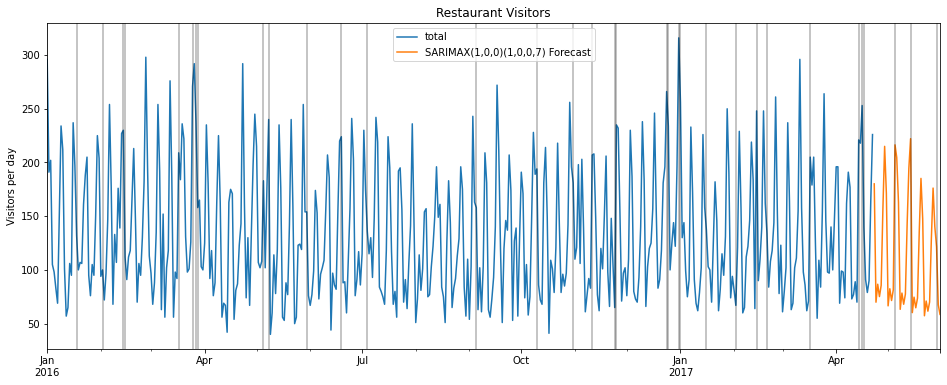

In [47]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

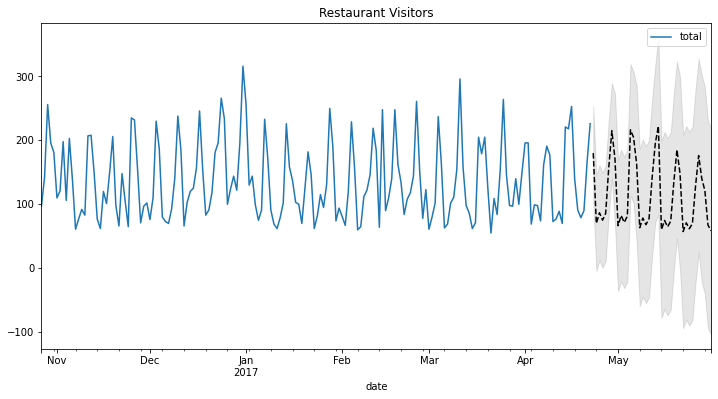

In [59]:
ax = df.iloc[300:]['total'].plot(legend=True,figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)

# Construct the forecasts
fcast = results.get_forecast(steps=39,exog=exog_forecast).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.10); #90% confidence